In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm

In [2]:
df_photo = pd.read_csv('./data/stripe82candidateVar_v1.1.dat',skiprows=5, header=1,index_col=0,sep='\s+')

In [3]:
#df_photo.head()

In [4]:
colnames = ['ID','Priority','Flags','Teff','eTeff','NTeff','logg','elogg','Nlogg','Z','eZ','NZ']
df_spec = pd.read_csv('./data/t3.txt',sep='\s+',skiprows=26,header=None,index_col=0,names=colnames)

In [5]:
#Combine both datasets 
df = pd.merge(df_spec, df_photo, on='ID',how='left')

In [6]:
df.head()

,Priority,Flags,Teff,eTeff,NTeff,logg,elogg,Nlogg,Z,eZ,...,ri,iz,gN,gAmpl,rN,rAmpl,iN,iAmpl,zQSO,MiQSO
ID,,,,,,,,,,,,,,,,,,,,,
4172970,4.0,nnnnn,5499.7,94.7,7,3.94,0.18,6,0.01,0.12,...,0.13,0.07,29,0.197,27,0.156,27,0.231,-9.9,-9.9
4583821,5.0,Nnnnn,4487.8,120.3,3,4.19,0.26,2,-0.95,0.08,...,0.30,0.16,50,0.124,49,0.106,51,0.094,-9.9,-9.9
4651452,2.0,NnBnX,-9999.0,-9999.0,0,-9999.00,-9999.00,0,-9999.00,-9999.00,...,-0.06,0.26,36,0.505,33,0.460,27,1.150,-9.9,-9.9
4777216,9.0,nnnnX,-9999.0,-9999.0,0,-9999.00,-9999.00,0,-9999.00,-9999.00,...,0.10,0.02,47,0.133,47,0.394,47,0.154,-9.9,-9.9
5302673,9.0,nnnnn,5986.7,161.8,4,3.93,0.79,2,-0.76,0.09,...,0.13,-0.05,36,0.332,33,0.175,39,0.253,-9.9,-9.9


In [7]:
df.columns

Index(['Priority', 'Flags', 'Teff', 'eTeff', 'NTeff', 'logg', 'elogg', 'Nlogg',
       'Z', 'eZ', 'NZ', 'ra', 'dec', 'P', 'r', 'ug', 'gr', 'ri', 'iz', 'gN',
       'gAmpl', 'rN', 'rAmpl', 'iN', 'iAmpl', 'zQSO', 'MiQSO'],
      dtype='object')

In [8]:
# Cleaning the training set not clearly mentioned in the paper. 
#Usign the entire dataset for now
#df = df[(df['Flags'] != 'nnnnn') & (df[Z] > -3.0)]

# Neural Network - Teff

In [9]:
df_nonan = df[df['Teff'] != -9999.0]

In [25]:
len(df_nonan)

3960

In [10]:
df_Y = df_nonan['Teff']

In [11]:
#Using just photometry and no light curve information
df_X = df_nonan[['ug','gr','ri','iz']]

In [27]:
train_X, test_X, train_y, test_y = train_test_split(df_X, df_Y, random_state=1, test_size=0.25)

In [28]:
train_stats = train_X.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
ug,2970.0,1.607599,0.507682,-0.05,1.19,1.48,1.97,3.19
gr,2970.0,0.605354,0.282562,-0.23,0.41,0.54,0.77,1.41
ri,2970.0,0.213303,0.137128,-0.27,0.13,0.18,0.27,1.22
iz,2970.0,0.080121,0.098160,-0.29,0.01,0.06,0.13,0.71


In [14]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_X)
# normed_test_data = norm(test_X)

In [31]:
test_y.describe()

count     990.000000
mean     5416.829394
std       671.423738
min      4006.200000
25%      4936.400000
50%      5465.550000
75%      5822.925000
max      8146.200000
Name: Teff, dtype: float64

In [18]:
"""
model_temp = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(train_X.columns),)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
"""

model_temp = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(train_X.columns),)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
])

In [19]:
adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [53]:
model_temp.compile(optimizer='adam',
              loss='mape',
              metrics=['mae', 'mse','msle','mape','kullback_leibler_divergence'])

In [55]:
history = model_temp.fit(normed_train_data, train_y, epochs=1000, batch_size=32, validation_split = 0.15)

Train on 2524 samples, validate on 446 samples
Epoch 1/1000
2524/2524 [==============================] - 1s 220us/sample - loss: 1.7719 - mae: 96.9963 - mse: 20148.9395 - msle: 6.1305e-04 - mape: 1.7719 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.8580 - val_mae: 101.1771 - val_mse: 23444.7246 - val_msle: 8.2575e-04 - val_mape: 1.8580 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 2/1000
2524/2524 [==============================] - 0s 43us/sample - loss: 1.7707 - mae: 96.9516 - mse: 20255.5664 - msle: 6.1691e-04 - mape: 1.7707 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.8777 - val_mae: 101.9439 - val_mse: 22856.6914 - val_msle: 8.0508e-04 - val_mape: 1.8777 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 3/1000
2524/2524 [==============================] - 0s 41us/sample - loss: 1.7791 - mae: 97.3127 - mse: 20239.4688 - msle: 6.1637e-04 - mape: 1.7791 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.8632 - val_mae: 101.1343 - val_mse: 23042.3203 - 

In [56]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,msle,mape,kullback_leibler_divergence,val_loss,val_mae,val_mse,val_msle,val_mape,val_kullback_leibler_divergence,epoch
995,1.737461,94.988106,18853.642578,0.000580,1.737462,0.0,1.886529,102.306084,23083.115234,0.000810,1.886529,0.0,995
996,1.746871,95.415924,19047.466797,0.000588,1.746871,0.0,1.883495,102.676254,23240.142578,0.000812,1.883495,0.0,996
997,1.738986,95.112724,18919.623047,0.000583,1.738986,0.0,1.848881,100.799118,23194.560547,0.000812,1.848881,0.0,997
998,1.738921,95.108574,19092.511719,0.000587,1.738921,0.0,1.894427,103.099739,23255.039062,0.000813,1.894427,0.0,998
999,1.738690,95.039459,18928.958984,0.000583,1.738689,0.0,1.895991,102.672989,23020.630859,0.000809,1.895990,0.0,999


In [41]:
loss, mae, mse = model_temp.evaluate(normed_test_data, test_y)

990/990 [==============================] - 0s 27us/sample - loss: 1.8982 - mse: 21603.0156 - mape: 1.8982


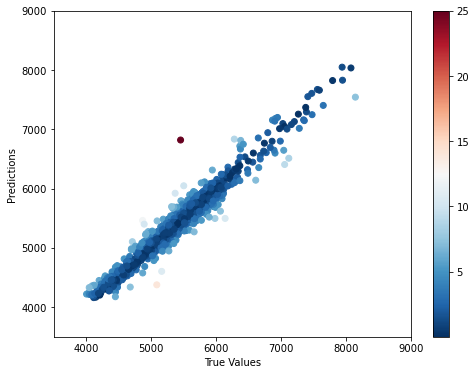

In [61]:
test_predictions = model_temp.predict(normed_test_data).flatten()
t_y = test_y.to_numpy()
error = 100*abs(t_y-test_predictions)/t_y

fig = plt.figure(1,figsize=(8,6))
plt.scatter(test_y, test_predictions,c=error,cmap='RdBu_r')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim(3500,9000)
plt.ylim(3500,9000)
plt.colorbar()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

In [62]:
np.std(error)

1.8991370418137845

# Neural Network - g

In [107]:
df_nonan = df[df['logg'] != -9999.0]

In [108]:
df_Y = df_nonan['logg']

In [109]:
train_X, test_X, train_y, test_y = train_test_split(df_X, df_Y, random_state=1, test_size=0.25)

In [110]:
train_stats = train_X.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
ug,2970.0,1.607599,0.507682,-0.05,1.19,1.48,1.97,3.19
gr,2970.0,0.605354,0.282562,-0.23,0.41,0.54,0.77,1.41
ri,2970.0,0.213303,0.137128,-0.27,0.13,0.18,0.27,1.22
iz,2970.0,0.080121,0.098160,-0.29,0.01,0.06,0.13,0.71


In [111]:
model_g = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(train_X.columns),)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
])

adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_g.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse','msle','mape','kullback_leibler_divergence'])

In [112]:
history = model_g.fit(normed_train_data, train_y, epochs=1000, batch_size=32, validation_split = 0.15)

Train on 2524 samples, validate on 446 samples
Epoch 1/1000
2524/2524 [==============================] - 1s 208us/sample - loss: 6.3942 - mae: 2.1982 - mse: 6.3942 - msle: 0.6425 - mape: 55.4974 - kullback_leibler_divergence: 0.5828 - val_loss: 2.4186 - val_mae: 1.3045 - val_mse: 2.4186 - val_msle: 0.1324 - val_mape: 32.9667 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 2/1000
2524/2524 [==============================] - 0s 43us/sample - loss: 1.4993 - mae: 0.9750 - mse: 1.4993 - msle: 0.0706 - mape: 25.4027 - kullback_leibler_divergence: -9.8919e-05 - val_loss: 0.8001 - val_mae: 0.6693 - val_mse: 0.8001 - val_msle: 0.0303 - val_mape: 17.3983 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 3/1000
2524/2524 [==============================] - 0s 42us/sample - loss: 0.5155 - mae: 0.5354 - mse: 0.5155 - msle: 0.0217 - mape: 14.4974 - kullback_leibler_divergence: -9.8919e-05 - val_loss: 0.3202 - val_mae: 0.4122 - val_mse: 0.3202 - val_msle: 0.0128 - val_mape: 10.9504 - val_kullbac

In [113]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,msle,mape,kullback_leibler_divergence,val_loss,val_mae,val_mse,val_msle,val_mape,val_kullback_leibler_divergence,epoch
995,0.101014,0.232952,0.101014,0.004844,6.359468,-0.000099,0.217311,0.327072,0.217311,0.010741,8.882051,0.0,995
996,0.100040,0.233120,0.100040,0.004832,6.360817,-0.000099,0.209722,0.312133,0.209722,0.010168,8.674693,0.0,996
997,0.099210,0.231850,0.099210,0.004778,6.323683,-0.000034,0.206751,0.319175,0.206751,0.010037,8.735590,0.0,997
998,0.101510,0.233349,0.101510,0.004945,6.377075,0.000561,0.209703,0.316752,0.209703,0.010121,8.808232,0.0,998
999,0.099772,0.232182,0.099772,0.004776,6.321054,-0.000034,0.212662,0.316868,0.212662,0.010233,8.754854,0.0,999


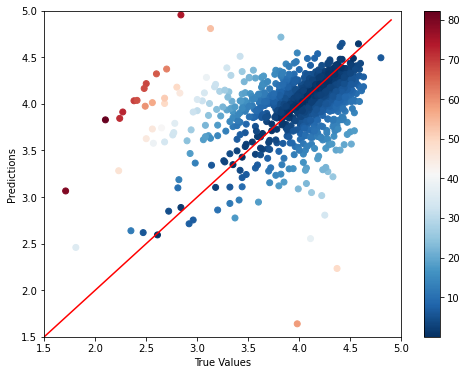

In [114]:
test_predictions = model_g.predict(normed_test_data).flatten()
t_y = test_y.to_numpy()
error = 100*abs(t_y-test_predictions)/t_y

x = np.arange(1.5,5,0.1)

fig = plt.figure(1,figsize=(8,6))
plt.scatter(test_y, test_predictions,c=error,cmap='RdBu_r')
plt.plot(x,x,'r-')
plt.plot()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim(1.5,5)
plt.ylim(1.5,5)
plt.colorbar()

# Neural Net - Metallicity

In [123]:
df_nonan = df[df['Z'] != -9999.0]

In [124]:
df_Y = df_nonan['Z']

In [125]:
train_X, test_X, train_y, test_y = train_test_split(df_X, df_Y, random_state=1, test_size=0.25)

In [126]:
train_stats = train_X.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
ug,2970.0,1.607599,0.507682,-0.05,1.19,1.48,1.97,3.19
gr,2970.0,0.605354,0.282562,-0.23,0.41,0.54,0.77,1.41
ri,2970.0,0.213303,0.137128,-0.27,0.13,0.18,0.27,1.22
iz,2970.0,0.080121,0.098160,-0.29,0.01,0.06,0.13,0.71


In [127]:
model_g = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(train_X.columns),)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
])

adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_g.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse','msle','mape','kullback_leibler_divergence'])

In [128]:
history = model_g.fit(normed_train_data, train_y, epochs=1000, batch_size=32, validation_split = 0.15)

Train on 2524 samples, validate on 446 samples
Epoch 1/1000
2524/2524 [==============================] - 1s 213us/sample - loss: 0.2225 - mae: 0.3613 - mse: 0.2225 - msle: 0.0011 - mape: 913507.3125 - kullback_leibler_divergence: 0.0328 - val_loss: 0.1420 - val_mae: 0.3013 - val_mse: 0.1420 - val_msle: 3.0507e-04 - val_mape: 1653181.0000 - val_kullback_leibler_divergence: 0.0329
Epoch 2/1000
2524/2524 [==============================] - 0s 44us/sample - loss: 0.1432 - mae: 0.2901 - mse: 0.1432 - msle: 3.6059e-04 - mape: 880758.7500 - kullback_leibler_divergence: 0.0328 - val_loss: 0.1315 - val_mae: 0.2799 - val_mse: 0.1315 - val_msle: 3.0507e-04 - val_mape: 1398155.2500 - val_kullback_leibler_divergence: 0.0329
Epoch 3/1000
2524/2524 [==============================] - 0s 41us/sample - loss: 0.1305 - mae: 0.2749 - mse: 0.1305 - msle: 3.6059e-04 - mape: 896511.3125 - kullback_leibler_divergence: 0.0328 - val_loss: 0.1294 - val_mae: 0.2744 - val_mse: 0.1294 - val_msle: 3.0507e-04 - val_map

In [129]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,msle,mape,kullback_leibler_divergence,val_loss,val_mae,val_mse,val_msle,val_mape,val_kullback_leibler_divergence,epoch
995,0.057260,0.183299,0.057260,0.000373,550386.81250,0.023946,0.150392,0.284451,0.150392,0.002174,222810.93750,0.032868,995
996,0.056888,0.182212,0.056888,0.000389,473953.15625,0.024365,0.154896,0.295763,0.154896,0.000679,250785.71875,0.032868,996
997,0.057877,0.182795,0.057877,0.000369,508677.78125,0.026707,0.150153,0.286362,0.150153,0.001836,266315.46875,0.032868,997
998,0.056582,0.180674,0.056582,0.000407,471471.78125,0.023691,0.151097,0.284824,0.151097,0.002552,340569.84375,0.032868,998
999,0.056270,0.181091,0.056270,0.000376,450172.34375,0.025620,0.144605,0.283307,0.144605,0.000838,304656.25000,0.032384,999


/Users/sreevani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


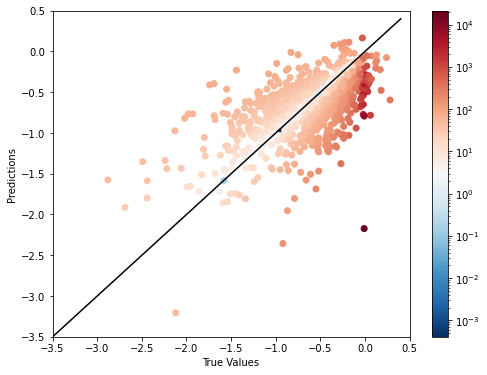

In [136]:
test_predictions = model_g.predict(normed_test_data).flatten()
t_y = test_y.to_numpy()
error = 100*abs((t_y-test_predictions)/t_y)

x = np.arange(-3.5,0.5,0.1)

fig = plt.figure(1,figsize=(8,6))
plt.scatter(test_y, test_predictions,c=error,cmap='RdBu_r',norm=LogNorm())
plt.plot(x,x,'k-')
plt.plot()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim(-3.5,0.5)
plt.ylim(-3.5,0.5)
plt.colorbar()

In [137]:
np.std(error)

/Users/sreevani/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


nan